# Анализ оценок вина

Установка нужных библиотек для машинного обучения:

In [110]:
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

for pkg in ["torch", "pandas", "numpy","matplotlib"]:
    install_if_missing(pkg)

In [111]:
import csv
import numpy as np
import torch
import math

In [112]:
wine_path = "data\wine.csv" # Путь к файлу с датасетом
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1) # Путь к бд, вид данных входных, разделить, пропустить первую строку т.к. там название столбцов
col_list = next(csv.reader(open(wine_path), delimiter=';'))
print(wineq_numpy, wineq_numpy.shape, wineq_numpy.dtype,'\n', '\n', col_list)


[[ 7.    0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 8.1   0.28  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.46  9.4   6.  ]
 [ 5.5   0.29  0.3  ...  0.38 12.8   7.  ]
 [ 6.    0.21  0.38 ...  0.32 11.8   6.  ]] (4898, 12) float32 
 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [113]:
wineq = torch.from_numpy(wineq_numpy)
print(wineq.shape, wineq.dtype)

torch.Size([4898, 12]) torch.float32


In [114]:
seed = 42
g = torch.Generator()
g.manual_seed(seed)

indices = torch.randperm(wineq.size(0), generator=g)

shuffled_data = wineq[indices]
print(shuffled_data, shuffled_data.shape, shuffled_data.dtype)

tensor([[ 6.8000,  0.3200,  0.3400,  ...,  0.4000,  9.1000,  5.0000],
        [ 7.2000,  0.3300,  0.3400,  ...,  0.5300, 13.3000,  7.0000],
        [ 7.3000,  0.2500,  0.2800,  ...,  0.5600, 10.1000,  6.0000],
        ...,
        [ 7.2000,  0.2400,  0.2900,  ...,  0.6400, 11.0000,  7.0000],
        [ 8.0000,  0.2200,  0.3100,  ...,  0.4200, 10.9000,  5.0000],
        [ 6.9000,  0.4100,  0.3300,  ...,  0.5200,  9.4000,  5.0000]]) torch.Size([4898, 12]) torch.float32


Разделение данных на признаки и оценки, а так же нормализация данных

In [115]:
data = shuffled_data[:, :-1]    # Все колонки кроме последней
target = shuffled_data[:, -1].long()   # Только последняя колонка

target_onehot = torch.zeros(target.shape[0], 10) # Создает матрицу высотой target, добавляет ширину 10 для оценок
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)

data_normilized = (data - data_mean) / torch.sqrt(data_var)

data_normilized.shape

torch.Size([4898, 11])

Разделение данных на тренировочные и тестовые

In [116]:
percent = 0.80

train_mount = math.trunc(percent*(data_normilized.shape[0]))
test_mount = data_normilized.shape[0] - train_mount

train_data = data_normilized[0:train_mount, :]
test_data = data_normilized[train_mount:data_normilized.shape[0], :]

train_target_onehot = target_onehot[0:train_mount, :]
test_target_onehot = target_onehot[train_mount:data_normilized.shape[0], :]

print(train_data.shape[0]+test_data.shape[0], '\n', train_target_onehot.shape[0]+test_target_onehot.shape[0])

4898 
 4898


In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [118]:
train_dataset = TensorDataset(train_data, train_target_onehot)
test_dataset = TensorDataset(test_data, test_target_onehot)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Создание класса нейросети

In [119]:
class WineNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(WineNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Softmax(dim=1)  # Для классификации (one-hot)
        )
        
    def forward(self, x):
        return self.model(x)

input_dim = train_data.shape[1]
output_dim = train_target_onehot.shape[1]
model = WineNet(input_dim, output_dim)

Функция потерь и оптимизатор:

In [120]:
criterion = nn.CrossEntropyLoss()  # Классификация
optimizer = optim.Adam(model.parameters(), lr=0.001)


Обучение модели

In [ ]:
epochs = 10000
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # CrossEntropyLoss ожидает метки, а не one-hot, поэтому:
        y_labels = torch.argmax(y_batch, dim=1)
        loss = criterion(outputs, y_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [5/50] - Loss: 1.9341
Epoch [10/50] - Loss: 1.9190
Epoch [15/50] - Loss: 1.9114
Epoch [20/50] - Loss: 1.9054
Epoch [25/50] - Loss: 1.9006
Epoch [30/50] - Loss: 1.8969
Epoch [35/50] - Loss: 1.8941
Epoch [40/50] - Loss: 1.8917
Epoch [45/50] - Loss: 1.8892
Epoch [50/50] - Loss: 1.8869


Оценка модели на тесте

In [122]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(y_batch, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 54.80%


Визуализация графика обучения

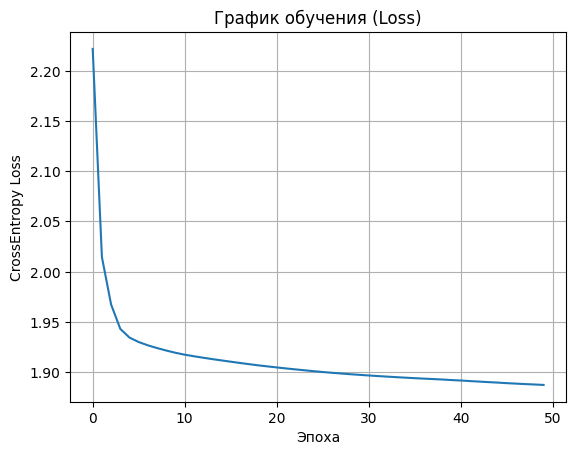

In [123]:
plt.plot(train_losses)
plt.title("График обучения (Loss)")
plt.xlabel("Эпоха")
plt.ylabel("CrossEntropy Loss")
plt.grid(True)
plt.show()